In [21]:
from PIL import Image
from IPython.display import SVG, display, clear_output
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch.autograd import Variable
import torchvision.transforms.functional as TF
import torchvision.transforms as T

from src.ShapeRenderer import ShapeRenderer
from src.ShapeRendererSVG import ShapeRendererSVG
from src.utils import unnormalize_functional, rgb_to_rgba, rgba_to_rgb, unnormalize_to
from src.models import Model

In [39]:
from torchvision import models
from torch import nn

class VGGContentLossMultiLayer(nn.Module):
    def __init__(self, layers = [26]):
        super(VGGContentLossMultiLayer, self).__init__()
        vgg = models.vgg19(pretrained=True).features.eval()
        
        for l in vgg:
            if isinstance(l, nn.ReLU):
                l = nn.ReLU(inplace=False)

        blocks = []
        last_ix = 0
        for ix in layers:
            blocks.append(vgg[last_ix:ix].eval())
            last_ix = ix
        for bl in blocks:
            for p in bl:
                p.requires_grad = False

        self.blocks = nn.ModuleList(blocks)
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        loss = 0.0
        for block in self.blocks:
            x = block(x.clone())
            y = block(y.clone())
            loss += self.criterion(x, y)
        return loss

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 128
n_shapes = 16
lr = 1e-2
image_path = r"G:\Simon\Pictures\zimonitrome\coel.png"

mean = [0.5, 0.5, 0.5]
std = [0.225, 0.225, 0.225]

basic_transforms = T.Compose([
    # T.Resize((image_size,image_size)),
    T.Resize(image_size),
    T.CenterCrop((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(mean, std),
])

target_tensor = basic_transforms(Image.open(image_path).convert("RGB")).to(device)
renderer = ShapeRenderer(device=device, imsize=image_size, minimum_sharpness=10).to(device)

parameters = Model.grid_init(n_shapes=n_shapes, n_parameter_fields=11).to(device)
parameters = Variable(parameters, requires_grad = True)

# def criterion(pred_image, target):
#     rgba_target = rgb_to_rgba(target)

#     return torch.nn.functional.l1_loss(pred_image, rgba_target)

# vgg_loss = VGGContentLossMultiLayer([3, 5, 10]).to(device)
vgg_loss = VGGContentLossMultiLayer().to(device)
def criterion(pred, target):
    rgb_pred = rgba_to_rgb(pred)
    rgb_target = target
    rgba_pred = pred
    rgba_target = rgb_to_rgba(target)

    content_loss = vgg_loss(rgb_pred.unsqueeze(0), rgb_target.unsqueeze(0))
    color_loss = 10*torch.nn.functional.l1_loss(rgba_pred, rgba_target)

    return content_loss + color_loss


optimizer = optim.Adam([parameters], lr=lr, betas=(0.5, 0.999))

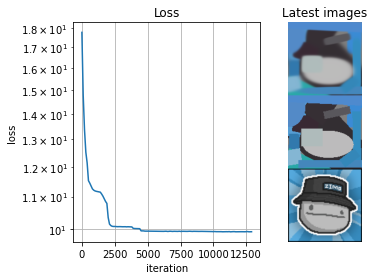

KeyboardInterrupt: 

In [56]:
losses = []

for i in range(20000+1):
    # "Train"
    optimizer.zero_grad()
    output_tensor = renderer(torch.sigmoid(parameters.unsqueeze(0))).squeeze(0)
    loss = criterion(output_tensor, target_tensor)
    loss.backward()
    optimizer.step()

    # Log
    if i % 100 == 0:
        losses.append(loss.item())
        renderer.eval()
        output_tensor_crisp = renderer(torch.sigmoid(parameters.unsqueeze(0))).squeeze(0)
        renderer.train()

        input_img = unnormalize_functional(target_tensor, mean, std)
        output_img = unnormalize_functional(rgba_to_rgb(output_tensor), mean, std)
        output_img_crip = unnormalize_functional(rgba_to_rgb(output_tensor_crisp), mean, std)

        combined_image = torch.concat([output_img, output_img_crip, input_img], -2)
        # print(f"i: {i}\tloss: {loss}")
        fig = plt.figure()
        fig.add_subplot(121)
        plt.plot(np.linspace(0, i, len(losses)), losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title("Loss")
        plt.yscale("log")
        plt.grid()

        fig.add_subplot(122)
        plt.axis('off')
        plt.imshow(combined_image.cpu().detach().numpy().transpose(1, 2, 0))
        plt.title("Latest images")

        fig.tight_layout()
        clear_output(wait=True)
        plt.show()

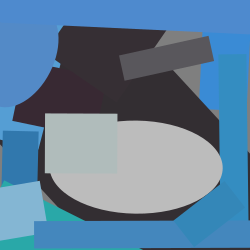

In [57]:
from src.ShapeRendererSVG import ShapeRendererSVG

svg_renderer = ShapeRendererSVG(renderer, canvas_size=250, mean=mean, std=std)
svg_renderer.save_png(torch.sigmoid(parameters), "./highres_outputs/zimo_vgg26+10l1.png")
svg_renderer.to_pil_image(torch.sigmoid(parameters))